In [1]:
!pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, AdamW, RMSprop
from tensorflow.keras import regularizers
import visualkeras
from PIL import ImageFont, Image
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

Total images in CSV: 2500
                                          image_path class_label
0  spectrograms/class_b/c10d61db-f912-48e2-a77d-f...     class_b
1  spectrograms/class_e/a56c037a-100f-46a2-93b5-e...     class_e
2  spectrograms/class_e/5f8c9f43-c3a0-4410-85e9-3...     class_e
3  spectrograms/class_c/bda8c954-f980-469f-b203-9...     class_c
4  spectrograms/class_e/01548d84-188f-4216-9438-f...     class_e


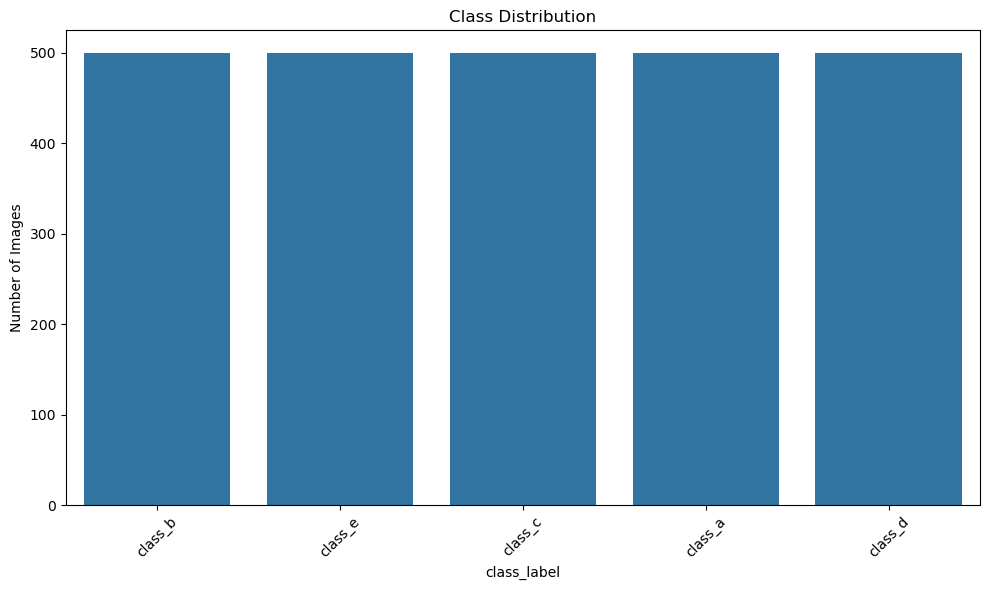

class_a: 500 images
class_b: 500 images
class_c: 500 images
class_d: 500 images
class_e: 500 images


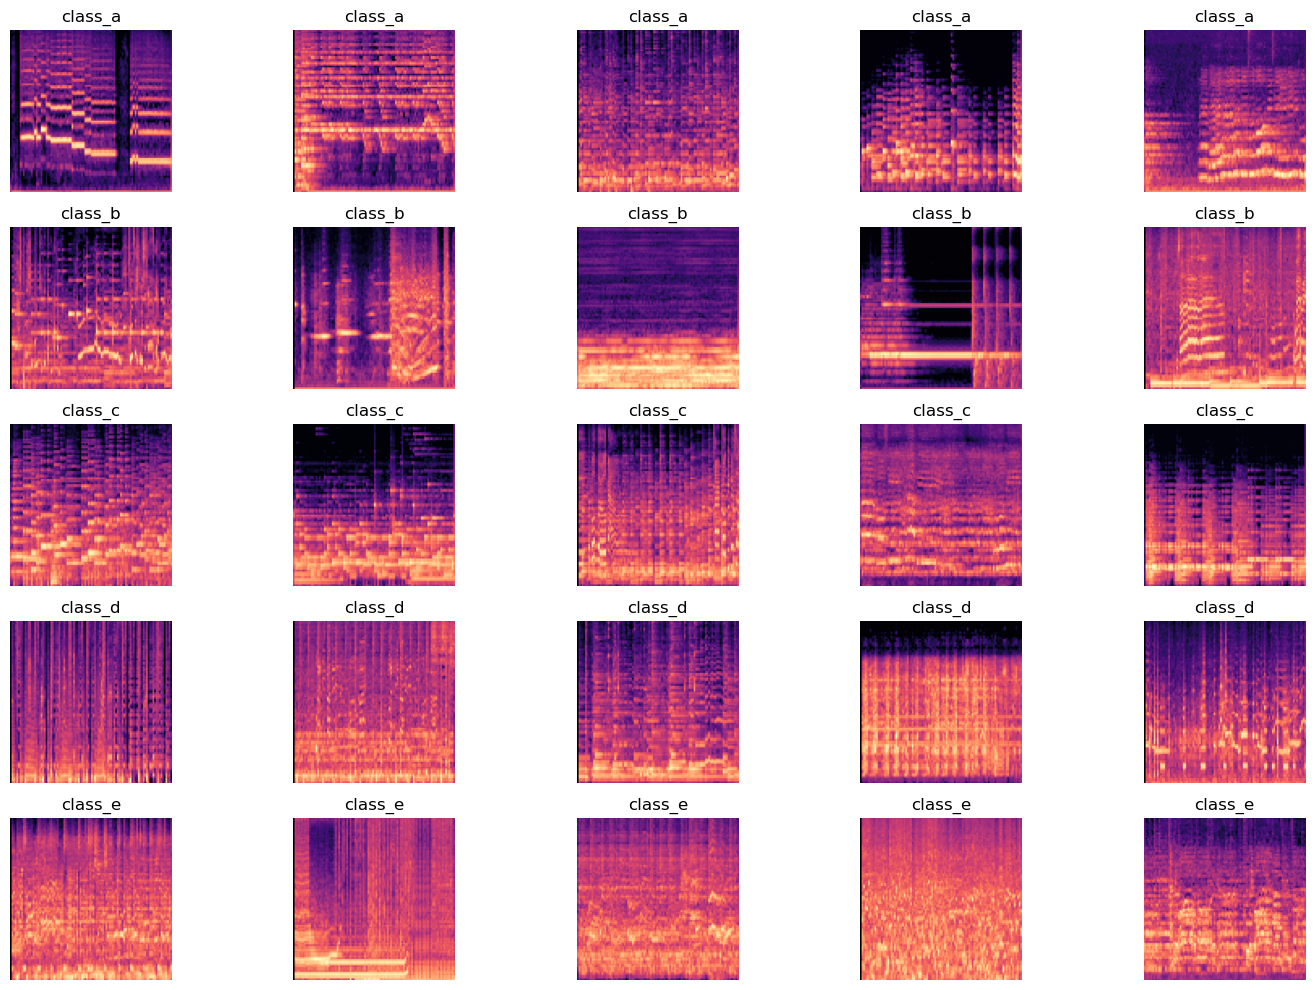

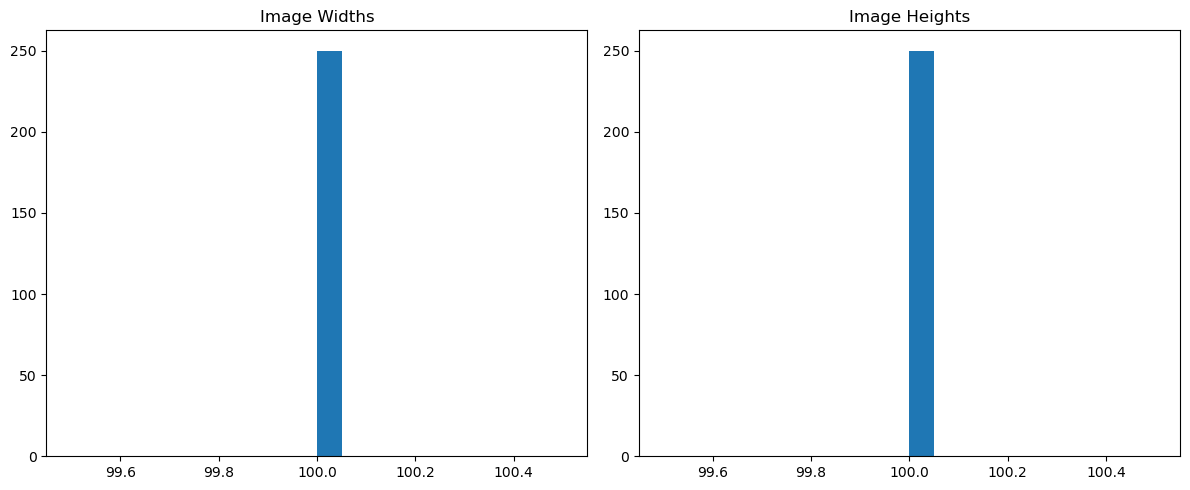

No corrupted images found.


In [3]:
# EDA
csv_path = "Dataset_CSC300_Assignment_3_ml_cnn/labels.csv"
df = pd.read_csv(csv_path)
print(f"Total images in CSV: {len(df)}")
print(df.head())

# Class Distribution Analysis
plt.figure(figsize=(10,6))
class_counts = df["class_label"].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# Verify folder structure and contents match cvs file
data_dir = "Dataset_CSC300_Assignment_3_ml_cnn"
class_folders = ["class_a", "class_b", "class_c", "class_d", "class_e"]
for folder in class_folders:
    folder_path = os.path.join(data_dir, folder)
    if os.path.exists(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"{folder}: {num_images} images")
    else:
        print(f"{folder} folder not found")

# Sample image visualisation, loop through class folders to display sample images
plt.figure(figsize=(15, 10))
for i, cls in enumerate(class_folders):
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)[:5]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            plt.subplot(5, 5, i*5+j+1)
            plt.imshow(img)
            plt.title(f"{cls}")
            plt.axis("off")
plt.tight_layout()
plt.show()

# Image dimensions analysis, ensure all images are the same size
widths = []
heights = []
for cls in class_folders:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        for img_name in random.sample(os.listdir(class_path), min(50, len(os.listdir(class_path)))):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                widths.append(img.width)
                heights.append(img.height)
            except Exception as e:
                print(f"Error with {img_path}: {e}")

# Create histograms of image dimensions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.title('Image Widths')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.title('Image Heights')
plt.tight_layout()
plt.show()

# Check for corrupt images
def check_corrupted_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify image integrity
                except Exception as e:
                    corrupted.append((file_path, str(e)))
    return corrupted

corrupted_images = check_corrupted_images(data_dir)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images:")
    for path, error in corrupted_images[:10]:  # Show first 10
        print(f"- {path}: {error}")
else:
    print("No corrupted images found.")

Found 2000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Class indices: {'class_a': 0, 'class_b': 1, 'class_c': 2, 'class_d': 3, 'class_e': 4}
Class distribution in training set:
Class 0: 400 images
Class 1: 400 images
Class 2: 400 images
Class 3: 400 images
Class 4: 400 images


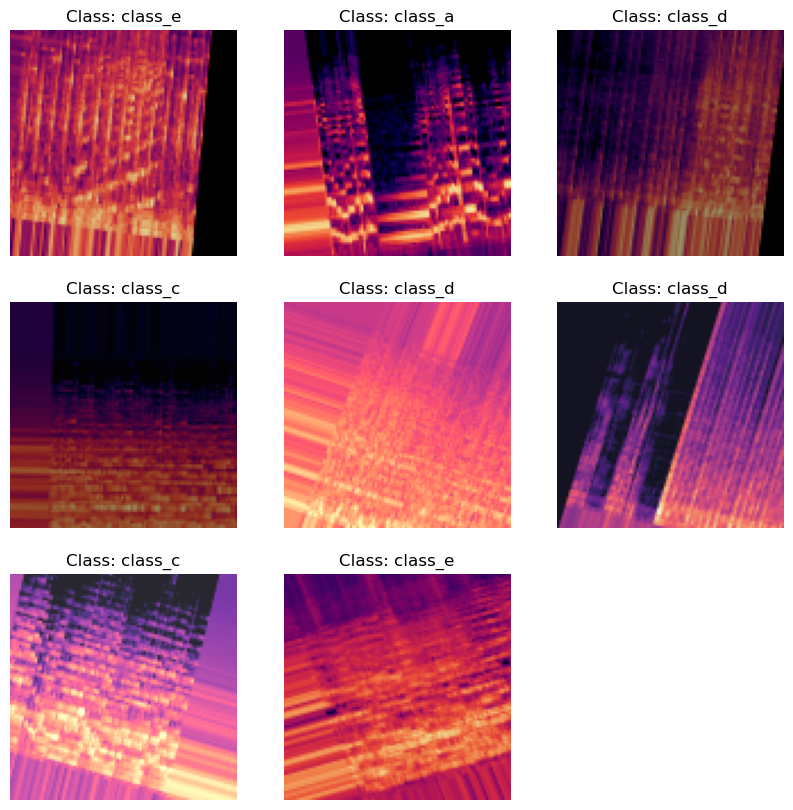

In [4]:
# Preprocessing
# Create data generators using csv
img_height, img_width = 100, 100
num_classes = 5
batch_size = 8 # from 32

# Define the generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=50, # Channel Shift
    # fill_mode="nearest", # Fill mode
    # vertical_flip=True,
    brightness_range=(0.6, 1.4), # Brightness variation
    validation_split=0.2,
    rotation_range=20,     
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,       
    horizontal_flip=True
)

# Only rescale for validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Flow from directory using the folder structure
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True # For randomisation
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # No need to shuffle validation data
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print class indices and check for class imbalance
print("Class indices:", train_generator.class_indices)
print("Class distribution in training set:")
for i in range(len(train_generator.classes)):
    if i > 4:
        break
    print(f"Class {i}: {np.sum(train_generator.classes == i)} images")

# Verify data loading by displaying a few images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        class_idx = np.argmax(label_batch[i])
        class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_idx)]
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()

# Get a batch of images and display them
images, labels = next(train_generator)
show_batch(images, labels)

In [5]:
# Basic CNN

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 5 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    verbose=1
)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,813,381 (18.36 MB)

 Trainable params: 4,813,381 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.2367 - loss: 1.6405 - val_accuracy: 0.3145 - val_loss: 1.5519
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2494 - loss: 1.5913 - val_accuracy: 0.3407 - val_loss: 1.5451
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.2878 - loss: 1.5631 - val_accuracy: 0.3387 - val_loss: 1.5411
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.2947 - loss: 1.5648 - val_accuracy: 0.3024 - val_loss: 1.5336
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3091 - loss: 1.5491 - val_accuracy: 0.3508 - val_loss: 1.5138
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3355 - loss: 1.5102 - val_accuracy: 0.3750 - val_loss: 1.4621
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3879 - loss: 1.4910 - val_accuracy: 0.3810 - val_loss: 1.4546
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3774 - loss: 1.4688 - val_accuracy: 0.41

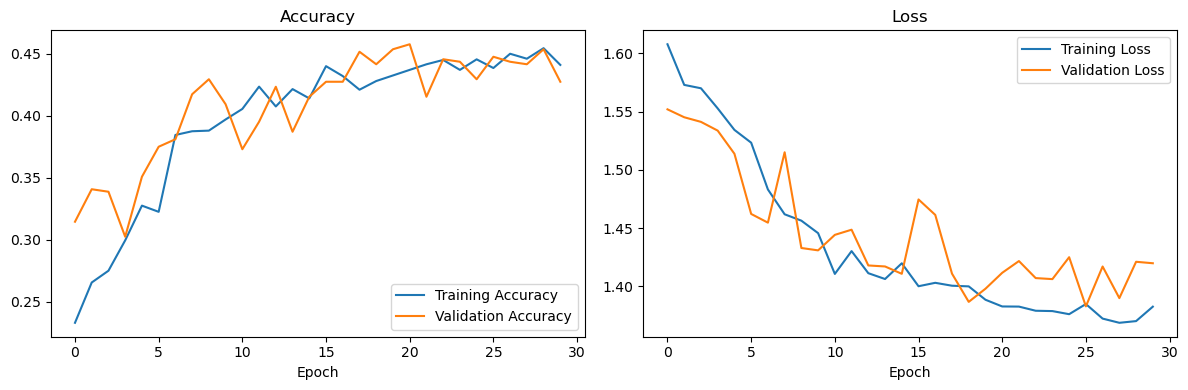

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4119 - loss: 1.4240 
Validation accuracy: 0.4240
Validation loss: 1.4212
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

     class_a       0.27      0.35      0.30       100
     class_b       0.61      0.52      0.56       100
     class_c       0.47      0.57      0.52       100
     class_d       0.45      0.41      0.43       100
     class_e       0.37      0.27      0.31       100

    accuracy                           0.42       500
   macro avg       0.43      0.42      0.42       500
weighted avg       0.43      0.42      0.42       500



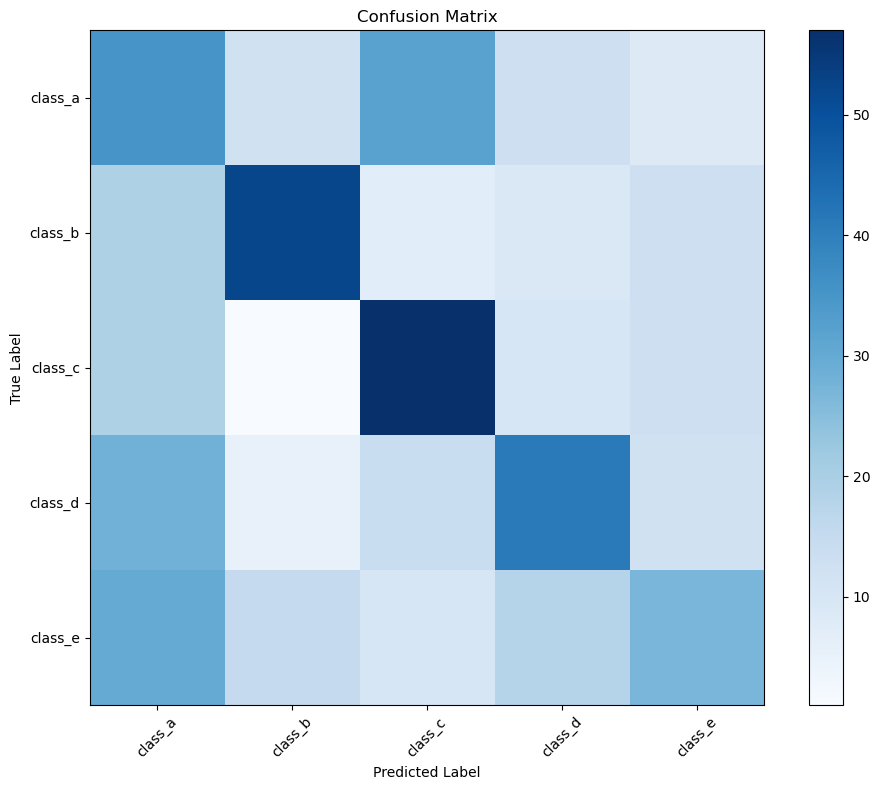

C:\Users\EliC1\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


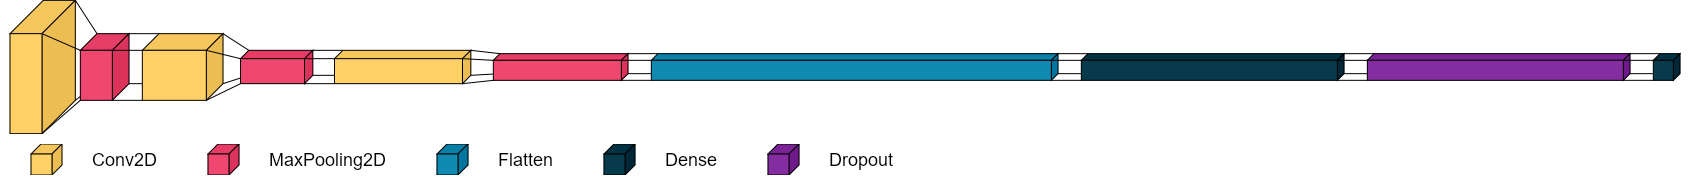

In [6]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Validation loss: {validation_loss:.4f}")

# Get predictions for confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Print classification report
class_names = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, 
                         font=font, 
                         spacing=30, 
                         legend=True,
                         scale_xy=1, scale_z=1) 

In [7]:
# Model with more Conv2D layers and early stopping and reduce learning callbacks
# Build CNN model
model = Sequential([
    # First convolutional block
    Conv2D(24, (6, 6), strides=1, activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    
    # Second convolutional block
    Conv2D(24, (6, 6), strides=1, activation='relu', padding='same', input_shape=(img_height, img_width, 24)),
    BatchNormalization(),
    
    # Third convolutional block
    Conv2D(48, (5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, 24)),
    BatchNormalization(),

    # Fourth convolutional block
    Conv2D(48, (5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, 48)),
    BatchNormalization(),

    # Fifth convolutional block
    Conv2D(64, (4, 4), strides=1, activation='relu', padding='same', input_shape=(img_height, img_width, 48)),
    BatchNormalization(),

    # Sixth convolutional block
    Conv2D(64, (4, 4), strides=1, activation='relu', padding='same', input_shape=(img_height, img_width, 64)),
    BatchNormalization(),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 5 classes
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor accuracy instead of loss
    patience=15,             # More patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor accuracy instead of loss
    factor=0.5,              # Less aggressive reduction
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model with fewer epochs to start
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,  # Start with fewer epochs
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 24)        │           2,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 24)        │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 24)        │          20,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 24)        │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 48)          │          28,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 25, 25, 48)          │          57,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 25, 25, 64)          │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 25, 25, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      10,240,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,467,317 (39.93 MB)

 Trainable params: 10,466,773 (39.93 MB)

 Non-trainable params: 544 (2.12 KB)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.2237 - loss: 2.3812 - val_accuracy: 0.2621 - val_loss: 1.5897 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.2358 - loss: 1.6267 - val_accuracy: 0.2944 - val_loss: 1.5354 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.2582 - loss: 1.6145 - val_accuracy: 0.2843 - val_loss: 1.5407 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.2230 - loss: 1.6150 - val_accuracy: 0.2964 - val_loss: 1.5614 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.2673 - loss: 1.6142 - val_accuracy: 0.3004 - val_loss: 1.5423 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.2560 - loss: 1.5966 - val_accuracy: 0.3669 - val_loss: 1.5177 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/ste

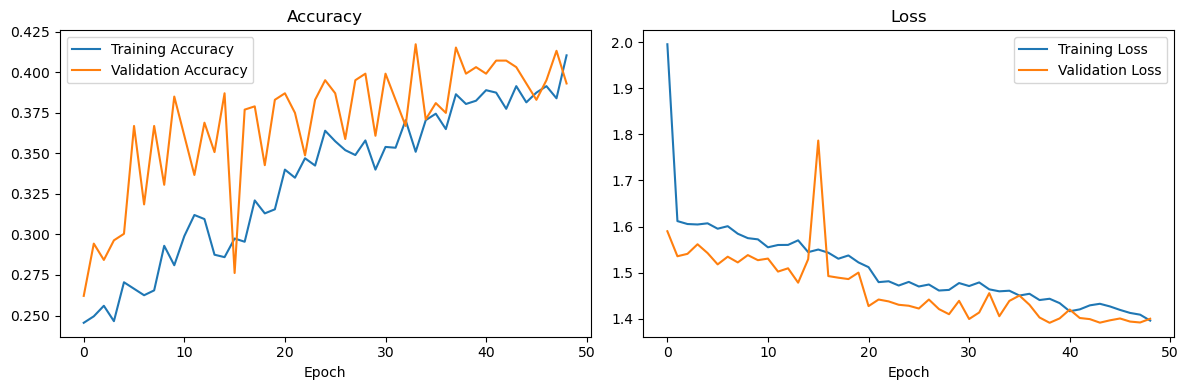

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3059 - loss: 1.3963
Validation accuracy: 0.4160
Validation loss: 1.4060
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

Classification Report:
              precision    recall  f1-score   support

     class_a       0.25      0.14      0.18       100
     class_b       0.63      0.42      0.50       100
     class_c       0.39      0.58      0.47       100
     class_d       0.46      0.52      0.49       100
     class_e       0.37      0.42      0.39       100

    accuracy                           0.42       500
   macro avg       0.42      0.42      0.41       500
weighted avg       0.42      0.42      0.41       500



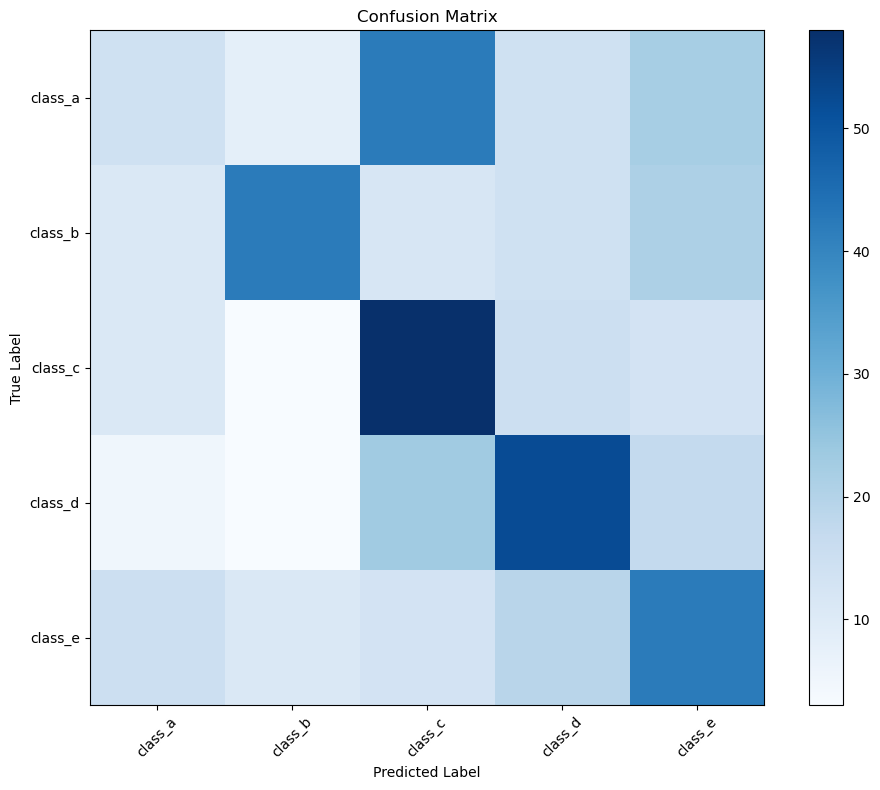

C:\Users\EliC1\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


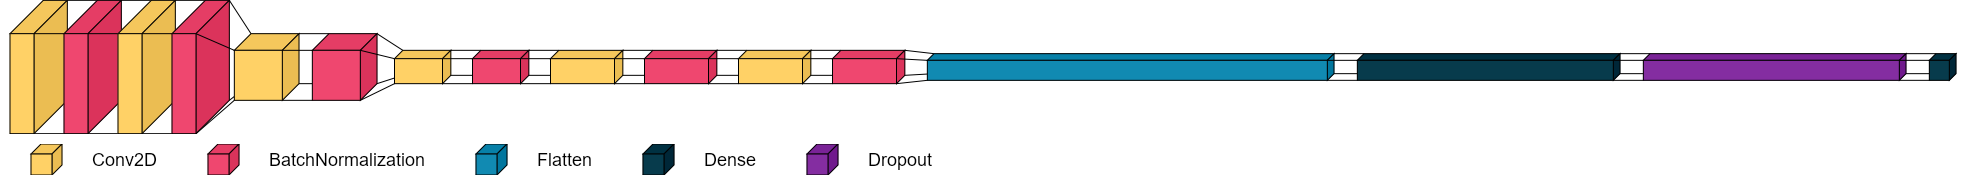

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Validation loss: {validation_loss:.4f}")

# Get predictions for confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Print classification report
class_names = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, 
                         font=font, 
                         spacing=30, 
                         legend=True,
                         scale_xy=1, scale_z=1) 

In [13]:
# Model with MaxPooling and regulasation
model = Sequential([
    # First convolutional block
    Conv2D(48, (3, 3), strides=(2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2, input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(86, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    
    # Fourth convolutional block
    Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Fifth convolutional block
    Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    
    # Sixth convolutional block
    Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 5 classes
])

# Compile the model with a lower learning rate
model.compile(
    # optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    # optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    # optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-4),
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Class weights
class_labels = np.array([0, 1, 2, 3, 4])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=(0, 1, 2, 3, 4)
)
class_weight_dict = {
    0: 1.2, # Under performing
    1: 0.8, # Over performing
    2: 1.2,
    3: 1,
    4: 1.2
}

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weight_dict,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 50, 50, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 50, 50, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 25, 25, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 13, 13, 64)          │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 6, 6, 86)            │          49,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 6, 6, 86)            │             344 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 6, 6, 128)           │          99,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 3, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,838,771 (10.83 MB)

 Trainable params: 2,836,583 (10.82 MB)

 Non-trainable params: 2,188 (8.55 KB)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2306 - loss: 14.7003 - val_accuracy: 0.1895 - val_loss: 13.5535 - learning_rate: 1.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2598 - loss: 13.0510 - val_accuracy: 0.2903 - val_loss: 11.0994 - learning_rate: 1.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.3052 - loss: 10.6892 - val_accuracy: 0.3105 - val_loss: 8.9579 - learning_rate: 1.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2959 - loss: 8.7735 - val_accuracy: 0.3448 - val_loss: 7.4616 - learning_rate: 1.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2958 - loss: 7.3345 - val_accuracy: 0.2802 - val_loss: 6.4173 - learning_rate: 1.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.3452 - loss: 6.2820 - val_accuracy: 0.4516 - val_loss: 5.4302 - learning_rate: 1.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28m

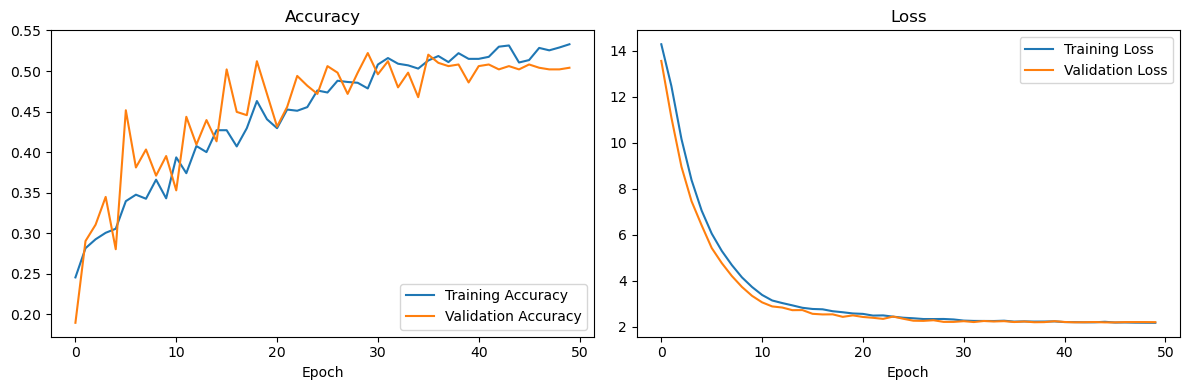

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5148 - loss: 2.2711 
Validation accuracy: 0.5220
Validation loss: 2.2181
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  

Classification Report:
              precision    recall  f1-score   support

     class_a       0.38      0.55      0.45       100
     class_b       0.73      0.43      0.54       100
     class_c       0.62      0.53      0.57       100
     class_d       0.56      0.54      0.55       100
     class_e       0.48      0.56      0.52       100

    accuracy                           0.52       500
   macro avg       0.56      0.52      0.53       500
weighted avg       0.56      0.52      0.53       500



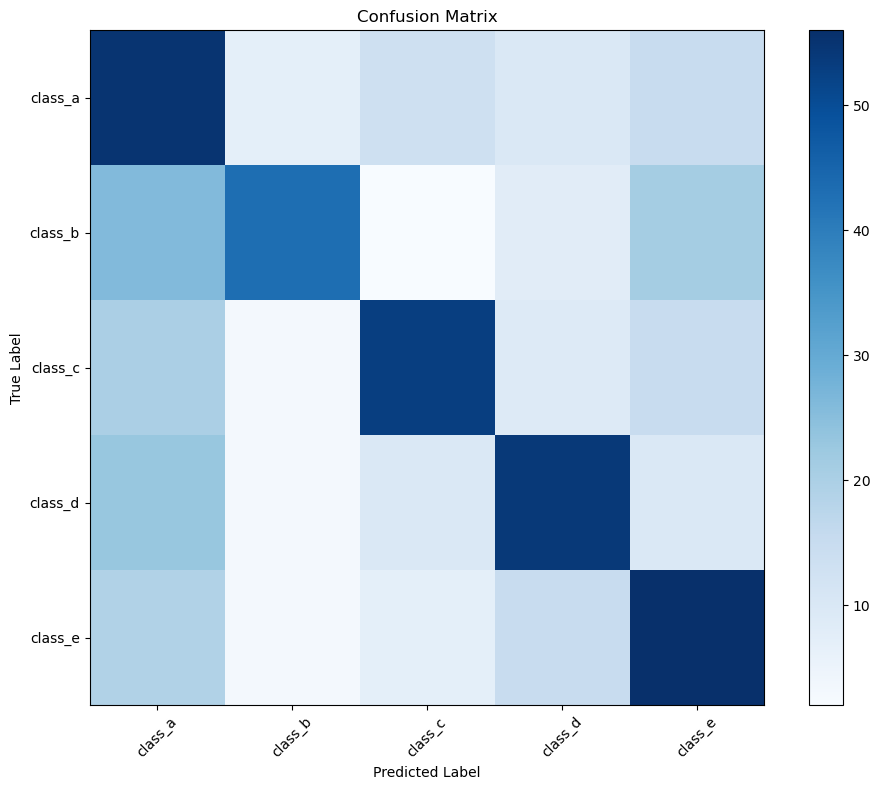

C:\Users\EliC1\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


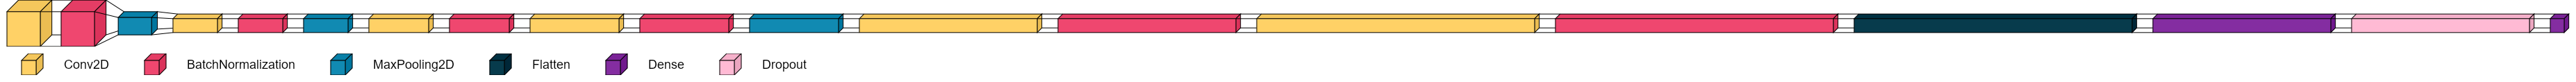

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Validation loss: {validation_loss:.4f}")

# Get predictions for confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Print classification report
class_names = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, 
                         font=font, 
                         spacing=30, 
                         legend=True,
                         scale_xy=1, scale_z=1) 

In [11]:
# 2 Models, one simple one complex
model = Sequential([
    # First convolutional block
    Conv2D(48, (3, 3), strides=(2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2, input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(86, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    
    # Fourth convolutional block
    Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Fifth convolutional block
    Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    
    # Sixth convolutional block
    Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2),
    BatchNormalization(),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 5 classes
])

model2 = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 5 classes
])

model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Compile the model with a lower learning rate
model.compile(
    # optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    # optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    # optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-4),
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()
model2.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', # from val_accuracy
    factor=0.5, # from 0.5
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Class weights
class_labels = np.array([0, 1, 2, 3, 4])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=(0, 1, 2, 3, 4)
)
class_weight_dict = {
    0: 1.2, # Under performing
    1: 0.9, # Over performing
    2: 1.2,
    3: 1,
    4: 1.2
}

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weight_dict,
    epochs=70,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weight_dict,
    epochs=70,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 50, 50, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 50, 50, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 25, 25, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 13, 13, 64)          │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 6, 6, 86)            │          49,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 6, 6, 86)            │             344 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 6, 6, 128)           │          99,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 3, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,838,771 (10.83 MB)

 Trainable params: 2,836,583 (10.82 MB)

 Non-trainable params: 2,188 (8.55 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,813,381 (18.36 MB)

 Trainable params: 4,813,381 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2572 - loss: 14.7777 - val_accuracy: 0.2016 - val_loss: 13.6568 - learning_rate: 1.0000e-04
Epoch 2/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.2636 - loss: 13.1095 - val_accuracy: 0.3609 - val_loss: 11.1391 - learning_rate: 1.0000e-04
Epoch 3/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3007 - loss: 10.7452 - val_accuracy: 0.3911 - val_loss: 9.0219 - learning_rate: 1.0000e-04
Epoch 4/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3221 - loss: 8.9780 - val_accuracy: 0.3488 - val_loss: 7.8707 - learning_rate: 1.0000e-04
Epoch 5/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3050 - loss: 7.8745 - val_accuracy: 0.4032 - val_loss: 6.9193 - learning_rate: 1.0000e-04
Epoch 6/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3482 - loss: 7.0036 - val_accuracy: 0.4294 - val_loss: 6.1631 - learning_rate: 1.0000e-04
Epoch 7/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step

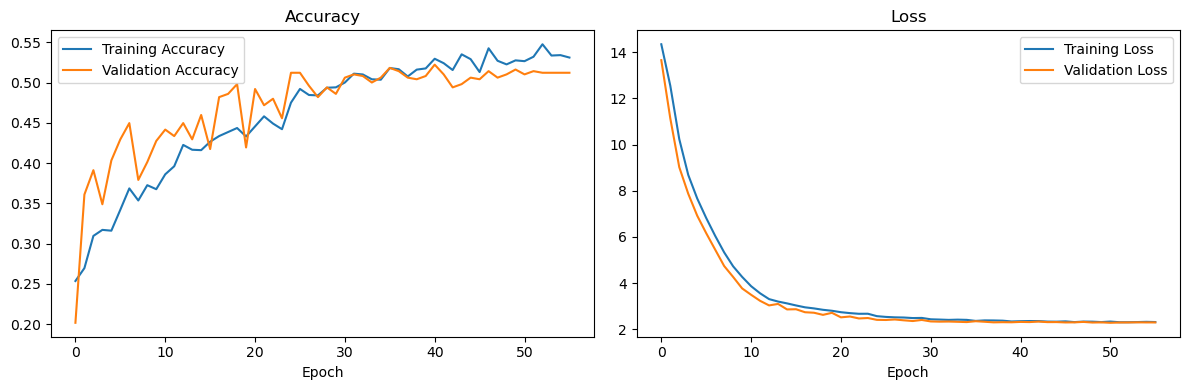

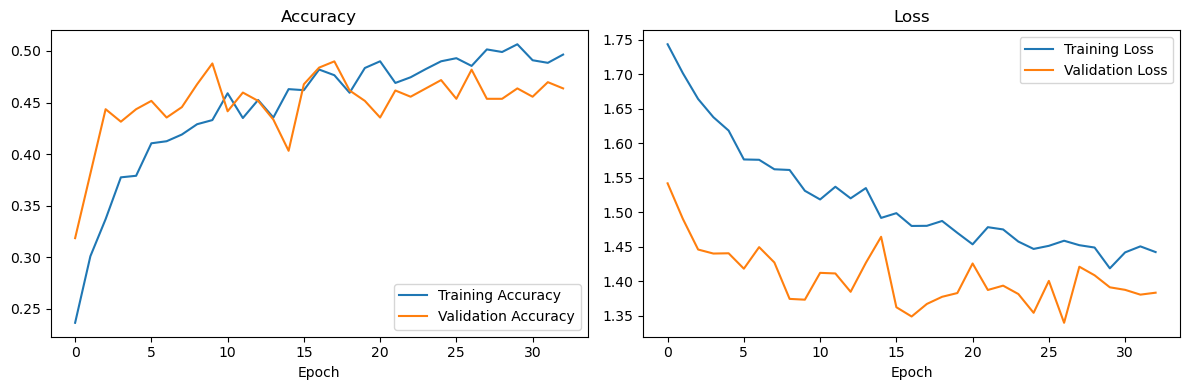

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5356 - loss: 2.2520 
Validation accuracy: 0.5200
Validation loss: 2.3244
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4655 - loss: 1.4027 
Validation accuracy: 0.4900
Validation loss: 1.3659
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

     class_a       0.42      0.49      0.45       100
     class_b       0.82      0.36      0.50       100
     class_c       0.51      0.58      0.54       100
     class_d       0.49      0.48      0.49       100
     class_e       0.42      0.54      0.47       100

    accuracy                           0.49       500
   macro avg       0.53      0.49      0.49       500
weighted avg       0.53      0.49      0.49       500



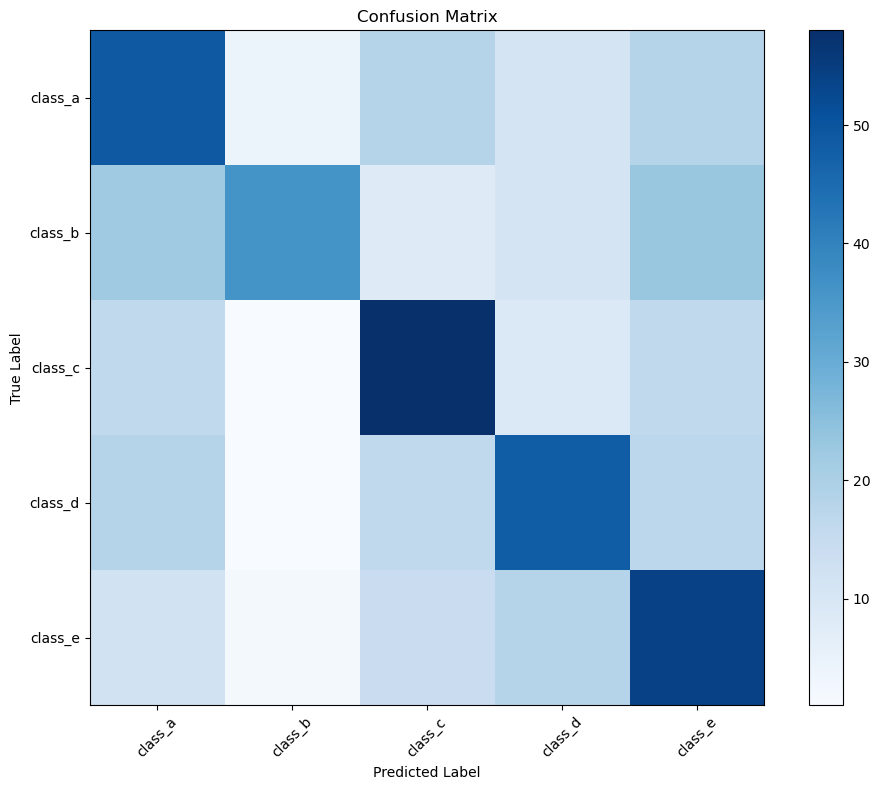

C:\Users\EliC1\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


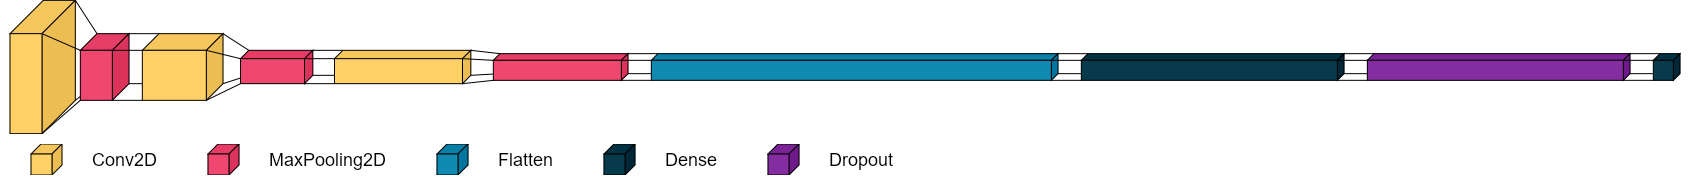

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Validation loss: {validation_loss:.4f}")

validation_loss, validation_accuracy = model2.evaluate(validation_generator)
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Validation loss: {validation_loss:.4f}")

# Get predictions for confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

predictions = model2.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Print classification report
class_names = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, 
                         font=font, 
                         spacing=30, 
                         legend=True,
                         scale_xy=1, scale_z=1) 

font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model2, 
                         font=font, 
                         spacing=30, 
                         legend=True,
                         scale_xy=1, scale_z=1) 

In [17]:
# Transfer Learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', # from val_accuracy
    factor=0.5, # from 0.5
    patience=5,
    min_lr=1e-6,
    verbose=1
)


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=70,
    callbacks = [early_stopping, reduce_lr],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

# Fine-tuning
# Unfreeze some layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    callbacks = [early_stopping, reduce_lr],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

# Save the model
model.save('transfer_learning_model.h5')

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 106, 106, 3)       │               0 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 50, 50, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 50, 50, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 50, 50, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 52, 52, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 25, 25, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 25, 25, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 25, 25, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 25, 25, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 25, 25, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 25, 25, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 25, 25, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 25, 25, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 25, 25, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.2040 - loss: 1.6814 - val_accuracy: 0.2016 - val_loss: 1.6268 - learning_rate: 1.0000e-04
Epoch 2/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.2077 - loss: 1.6396 - val_accuracy: 0.2016 - val_loss: 1.6600 - learning_rate: 1.0000e-04
Epoch 3/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.2163 - loss: 1.6440 - val_accuracy: 0.1996 - val_loss: 1.5983 - learning_rate: 1.0000e-04
Epoch 4/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.2185 - loss: 1.6284 - val_accuracy: 0.2016 - val_loss: 1.6689 - learning_rate: 1.0000e-04
Epoch 5/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.2413 - loss: 1.6394 - val_accuracy: 0.2560 - val_loss: 1.6339 - learning_rate: 1.0000e-04
Epoch 6/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.2227 - loss: 1.6403 - val_accuracy: 0.2480 - val_loss: 1.6268 - learning_rate: 1.0000e-04
Epoch 7/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/st

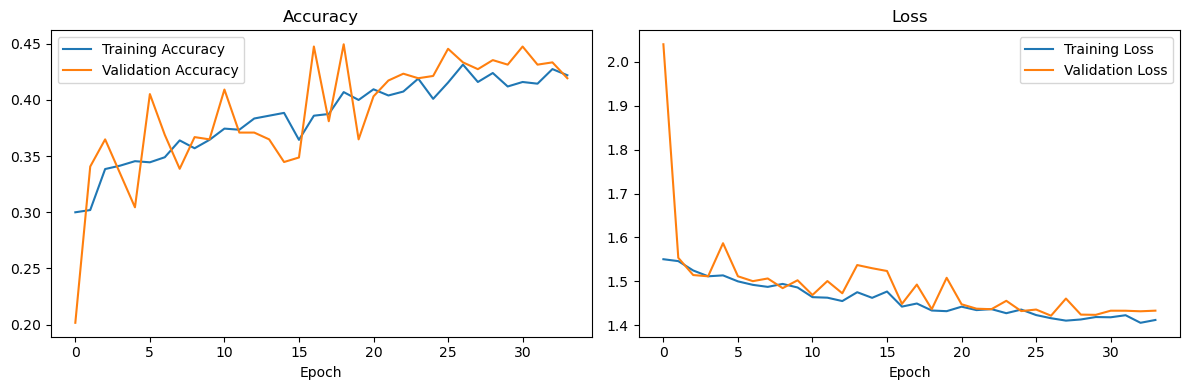

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4980 - loss: 1.3264
Validation accuracy: 0.4480
Validation loss: 1.4372
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step

Classification Report:
              precision    recall  f1-score   support

     class_a       0.35      0.55      0.43       100
     class_b       0.47      0.55      0.51       100
     class_c       0.56      0.40      0.47       100
     class_d       0.46      0.46      0.46       100
     class_e       0.48      0.28      0.35       100

    accuracy                           0.45       500
   macro avg       0.47      0.45      0.44       500
weighted avg       0.47      0.45      0.44       500



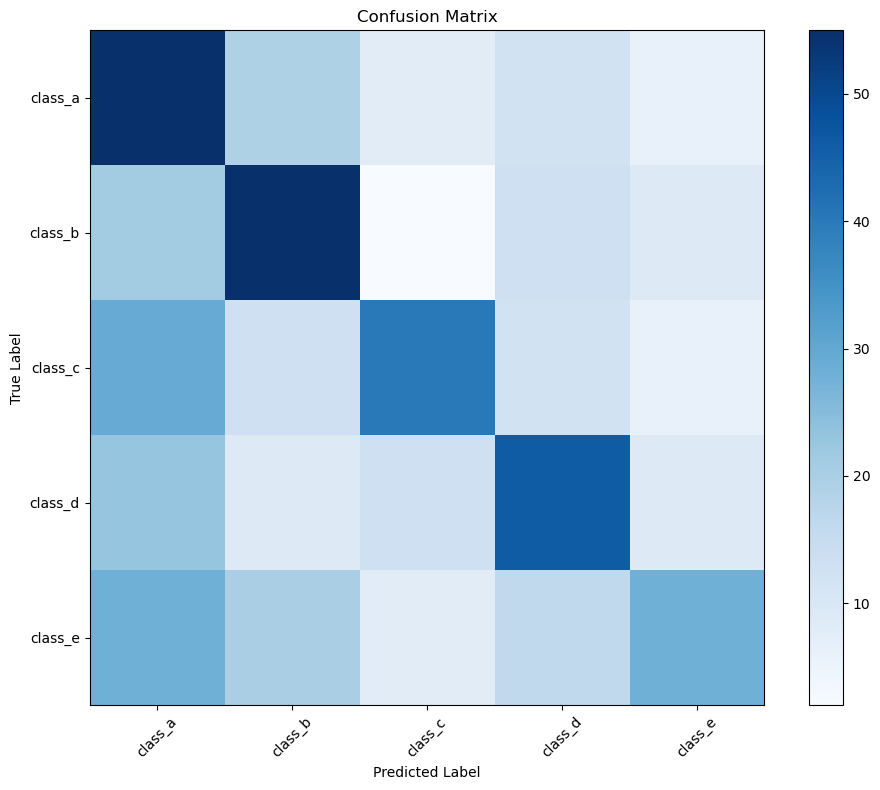

C:\Users\EliC1\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


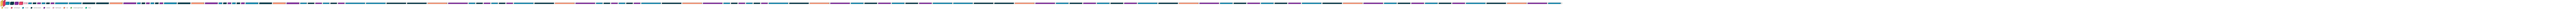

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Validation loss: {validation_loss:.4f}")

# Get predictions for confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Print classification report
class_names = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, 
                         font=font, 
                         spacing=30, 
                         legend=True,
                         scale_xy=1, scale_z=1) 